# 03 - Training & Evaluation

**Objectif**: Entraîner et évaluer différents modèles de classification pour prédire le gagnant d'un combat Pokémon 1v1.

**Input**: Features préparées dans `data/ml/battle_winner/features/` (v1) ou `data/ml/battle_winner_v2/features/` (v2)

**Output**: Modèle entraîné exporté dans `models/` avec évaluation par scénario pour v2

**Date**: 2026-01-24

---

## Table des Matières

1. [Chargement des Données](#1-chargement-des-données)
2. [Baseline: Logistic Regression](#2-baseline-logistic-regression)
3. [Random Forest](#3-random-forest)
4. [XGBoost](#4-xgboost)
5. [Comparaison des Modèles](#5-comparaison-des-modèles)
6. [Analyse des Feature Importances](#6-analyse-des-feature-importances)
7. [Export du Modèle Final](#7-export-du-modèle-final)
8. [Conclusion](#8-conclusion)

## 1. Chargement des Données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost non installé, utilisation de Random Forest uniquement")

# Configuration
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# Chemins - Détection automatique v1/v2
BASE_DIR_V1 = Path('../data/ml/battle_winner')
BASE_DIR_V2 = Path('../data/ml/battle_winner_v2')

# Vérifier quelle version est disponible
if BASE_DIR_V2.exists():
    BASE_DIR = BASE_DIR_V2
    DATASET_VERSION = 'v2'
    print(f"📦 Dataset v2 détecté (multi-scénarios)")
else:
    BASE_DIR = BASE_DIR_V1
    DATASET_VERSION = 'v1'
    print(f"📦 Dataset v1 détecté (best_move uniquement)")

FEATURES_DIR = BASE_DIR / 'features'
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

# Seed pour reproductibilité
RANDOM_STATE = 42

print(f"✅ Bibliothèques chargées")
print(f"✅ XGBoost disponible: {XGBOOST_AVAILABLE}")
print(f"✅ Version dataset: {DATASET_VERSION}")

📦 Dataset v2 détecté (multi-scénarios)
✅ Bibliothèques chargées
✅ XGBoost disponible: True
✅ Version dataset: v2


In [2]:
# Chargement des features
X_train = pd.read_parquet(FEATURES_DIR / 'X_train.parquet')
X_test = pd.read_parquet(FEATURES_DIR / 'X_test.parquet')
y_train = pd.read_parquet(FEATURES_DIR / 'y_train.parquet')['winner']
y_test = pd.read_parquet(FEATURES_DIR / 'y_test.parquet')['winner']

# Vérifier si scenario_type existe
if 'scenario_type' in X_train.columns:
    print(f"✅ scenario_type détecté - analyse multi-scénarios possible")
    scenario_train = X_train['scenario_type'].copy()
    scenario_test = X_test['scenario_type'].copy()
    
    # Retirer scenario_type des features pour l'entraînement
    X_train_ml = X_train.drop(columns=['scenario_type'])
    X_test_ml = X_test.drop(columns=['scenario_type'])
    
    HAS_SCENARIOS = True
    print(f"\n📊 Distribution des scénarios (train):")
    print(scenario_train.value_counts())
else:
    print(f"⚠️ Pas de scenario_type - dataset v1")
    X_train_ml = X_train
    X_test_ml = X_test
    scenario_train = None
    scenario_test = None
    HAS_SCENARIOS = False

print(f"\n✅ Données chargées")
print(f"   X_train: {X_train_ml.shape}")
print(f"   X_test: {X_test_ml.shape}")
print(f"   y_train: {y_train.shape} | Distribution: {y_train.value_counts().to_dict()}")
print(f"   y_test: {y_test.shape} | Distribution: {y_test.value_counts().to_dict()}")

✅ scenario_type détecté - analyse multi-scénarios possible

📊 Distribution des scénarios (train):
scenario_type
all_combinations    551824
random_move         139128
best_move            27825
Name: count, dtype: int64

✅ Données chargées
   X_train: (718777, 133)
   X_test: (179695, 133)
   y_train: (718777,) | Distribution: {1: 389269, 0: 329508}
   y_test: (179695,) | Distribution: {1: 97318, 0: 82377}


In [3]:
# Dictionnaire pour stocker les résultats
results = {}

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Entraîne et évalue un modèle.
    Retourne un dictionnaire avec les métriques.
    """
    print(f"\n{'='*80}")
    print(f"🤖 {model_name}")
    print(f"{'='*80}")
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"⏱️ Temps d'entraînement: {train_time:.2f}s")
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métriques Train
    train_acc = accuracy_score(y_train, y_pred_train)
    
    # Métriques Test
    test_acc = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None
    
    print(f"\n📊 Résultats:")
    print(f"   Train Accuracy: {train_acc:.4f}")
    print(f"   Test Accuracy:  {test_acc:.4f}")
    print(f"   Test Precision: {test_precision:.4f}")
    print(f"   Test Recall:    {test_recall:.4f}")
    print(f"   Test F1-Score:  {test_f1:.4f}")
    if test_roc_auc:
        print(f"   Test ROC-AUC:   {test_roc_auc:.4f}")
    
    # Overfitting check
    overfit_gap = train_acc - test_acc
    if overfit_gap > 0.05:
        print(f"   ⚠️ Overfitting détecté (gap: {overfit_gap:.4f})")
    else:
        print(f"   ✅ Pas d'overfitting significatif (gap: {overfit_gap:.4f})")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_time': train_time,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_pred_test': y_pred_test,
        'y_proba_test': y_proba_test
    }

print("✅ Fonction d'évaluation définie")

✅ Fonction d'évaluation définie


## 2. Baseline: Logistic Regression

In [4]:
# Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='lbfgs',
    n_jobs=-1
)

results['Logistic Regression'] = evaluate_model(
    lr_model, X_train_ml, X_test_ml, y_train, y_test, 'Logistic Regression'
)


🤖 Logistic Regression
⏱️ Temps d'entraînement: 9.82s

📊 Résultats:
   Train Accuracy: 0.8931
   Test Accuracy:  0.8940
   Test Precision: 0.9000
   Test Recall:    0.9048
   Test F1-Score:  0.9024
   Test ROC-AUC:   0.9596
   ✅ Pas d'overfitting significatif (gap: -0.0009)


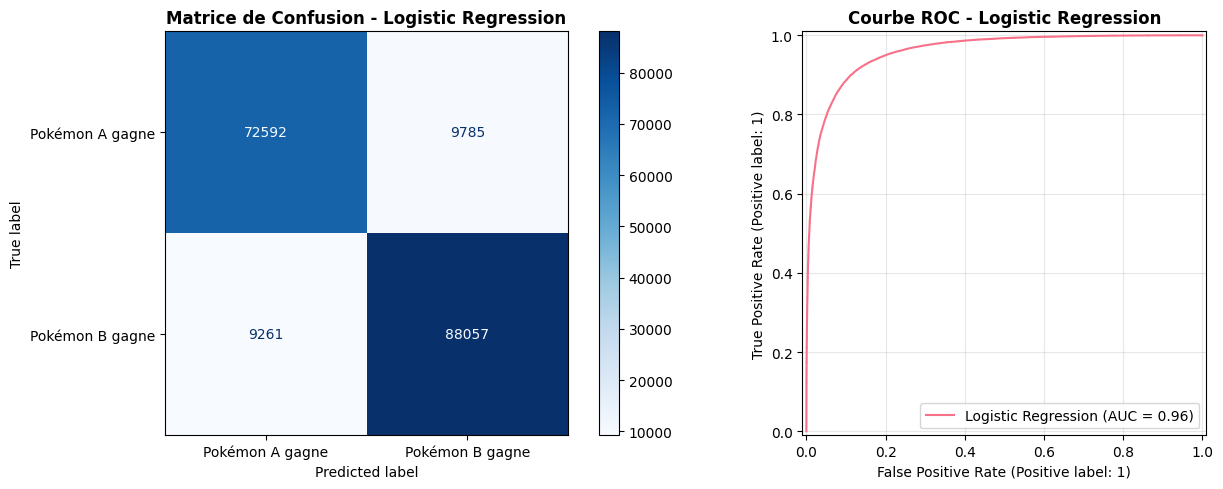

In [5]:
# Matrice de confusion - Logistic Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, results['Logistic Regression']['y_pred_test'],
    display_labels=['Pokémon A gagne', 'Pokémon B gagne'],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title('Matrice de Confusion - Logistic Regression', fontsize=12, fontweight='bold')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, results['Logistic Regression']['y_proba_test'],
    ax=axes[1], name='Logistic Regression'
)
axes[1].set_title('Courbe ROC - Logistic Regression', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Random Forest

In [6]:
# Random Forest avec GridSearchCV (fast)
print("\n🔍 GridSearchCV pour Random Forest...")

# Grille de paramètres rapide
param_grid_rf_fast = {
    'n_estimators': [50, 100],
    'max_depth': [15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
grid_rf = GridSearchCV(
    rf_base, param_grid_rf_fast, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=1
)

print("⏱️ Entraînement en cours...")
grid_rf.fit(X_train_ml, y_train)

print(f"\n✅ Meilleurs paramètres: {grid_rf.best_params_}")
print(f"✅ Meilleur score CV: {grid_rf.best_score_:.4f}")

# Utiliser le meilleur modèle
rf_model = grid_rf.best_estimator_
results['Random Forest'] = evaluate_model(
    rf_model, X_train_ml, X_test_ml, y_train, y_test, 'Random Forest (GridSearch)'
)


🔍 GridSearchCV pour Random Forest...
⏱️ Entraînement en cours...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
✅ Meilleur score CV: 0.9376

🤖 Random Forest (GridSearch)
⏱️ Temps d'entraînement: 35.01s

📊 Résultats:
   Train Accuracy: 0.9746
   Test Accuracy:  0.9414
   Test Precision: 0.9440
   Test Recall:    0.9481
   Test F1-Score:  0.9460
   Test ROC-AUC:   0.9890
   ✅ Pas d'overfitting significatif (gap: 0.0332)


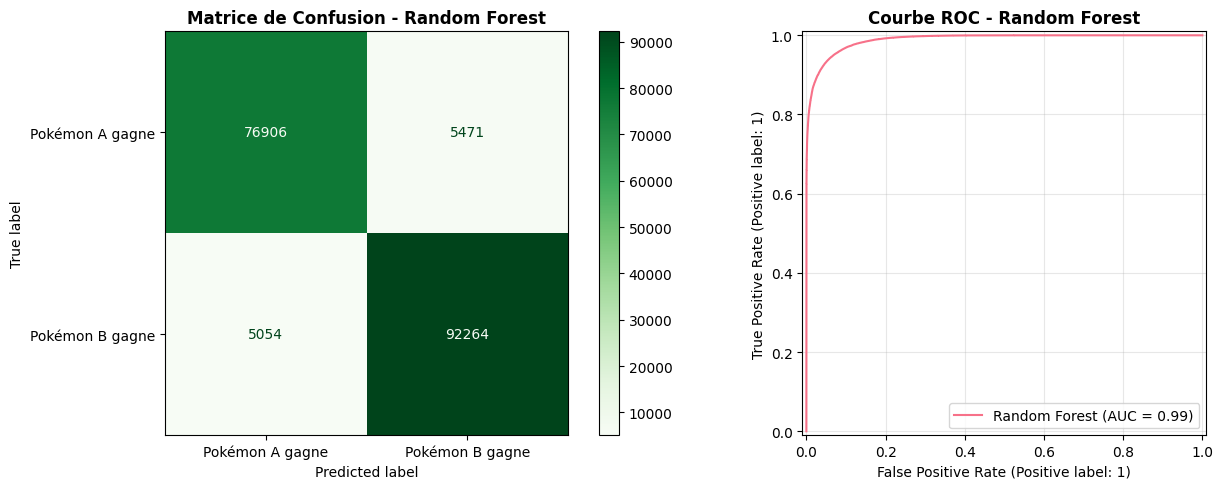

In [7]:
# Matrice de confusion - Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, results['Random Forest']['y_pred_test'],
    display_labels=['Pokémon A gagne', 'Pokémon B gagne'],
    cmap='Greens', ax=axes[0]
)
axes[0].set_title('Matrice de Confusion - Random Forest', fontsize=12, fontweight='bold')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, results['Random Forest']['y_proba_test'],
    ax=axes[1], name='Random Forest'
)
axes[1].set_title('Courbe ROC - Random Forest', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. XGBoost

In [8]:
if XGBOOST_AVAILABLE:
    print("\n🔍 GridSearchCV pour XGBoost...")
    
    # Grille de paramètres rapide
    param_grid_xgb_fast = {
        'n_estimators': [50, 100],
        'max_depth': [6, 8],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    
    xgb_base = XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    grid_xgb = GridSearchCV(
        xgb_base, param_grid_xgb_fast, cv=3, scoring='accuracy',
        n_jobs=-1, verbose=1
    )
    
    print("⏱️ Entraînement en cours...")
    grid_xgb.fit(X_train_ml, y_train)
    
    print(f"\n✅ Meilleurs paramètres: {grid_xgb.best_params_}")
    print(f"✅ Meilleur score CV: {grid_xgb.best_score_:.4f}")
    
    # Utiliser le meilleur modèle
    xgb_model = grid_xgb.best_estimator_
    results['XGBoost'] = evaluate_model(
        xgb_model, X_train_ml, X_test_ml, y_train, y_test, 'XGBoost (GridSearch)'
    )
else:
    print("⚠️ XGBoost non disponible, passage à la section suivante")


🔍 GridSearchCV pour XGBoost...
⏱️ Entraînement en cours...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Meilleurs paramètres: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}
✅ Meilleur score CV: 0.9418

🤖 XGBoost (GridSearch)
⏱️ Temps d'entraînement: 6.27s

📊 Résultats:
   Train Accuracy: 0.9497
   Test Accuracy:  0.9446
   Test Precision: 0.9480
   Test Recall:    0.9498
   Test F1-Score:  0.9489
   Test ROC-AUC:   0.9902
   ✅ Pas d'overfitting significatif (gap: 0.0052)


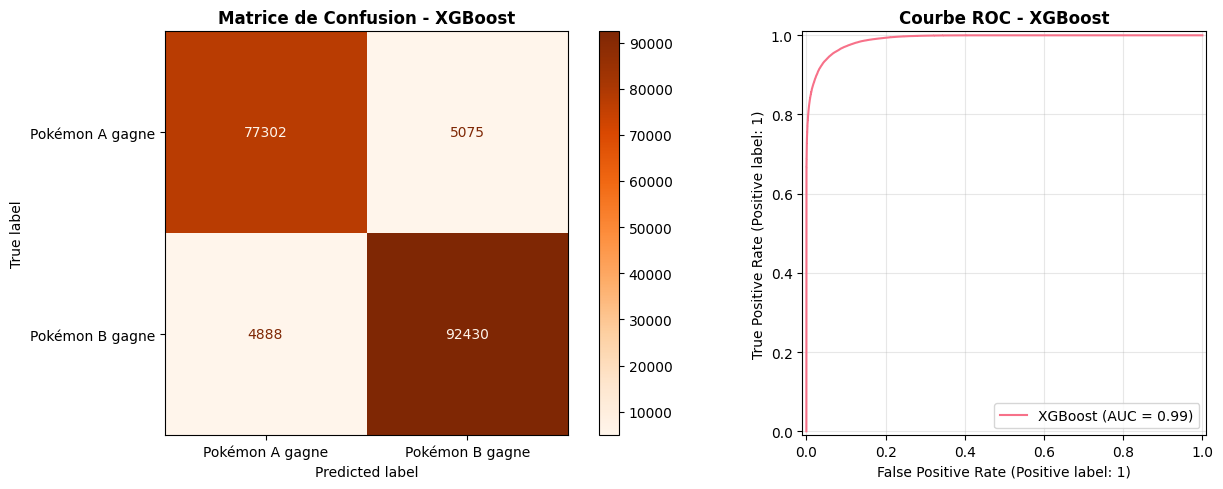

In [9]:
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    # Matrice de confusion - XGBoost
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, results['XGBoost']['y_pred_test'],
        display_labels=['Pokémon A gagne', 'Pokémon B gagne'],
        cmap='Oranges', ax=axes[0]
    )
    axes[0].set_title('Matrice de Confusion - XGBoost', fontsize=12, fontweight='bold')
    
    # ROC Curve
    RocCurveDisplay.from_predictions(
        y_test, results['XGBoost']['y_proba_test'],
        ax=axes[1], name='XGBoost'
    )
    axes[1].set_title('Courbe ROC - XGBoost', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 4.1 XGBoost avec GridSearchCV

In [11]:
if XGBOOST_AVAILABLE:
    print("=" * 80)
    print("🔍 XGBOOST AVEC GRIDSEARCHCV - RECHERCHE D'HYPERPARAMÈTRES")
    print("=" * 80)
    
    # Grille étendue d'hyperparamètres (243 combinaisons)
    param_grid_extended = {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }
    
    print(f"\n📊 Grille d'hyperparamètres:")
    for param, values in param_grid_extended.items():
        print(f"   {param:20s}: {values}")
    
    total_combinations = np.prod([len(v) for v in param_grid_extended.values()])
    print(f"\n✅ Total combinaisons: {total_combinations}")
    print(f"⏱️ Estimation du temps (avec CV=3): ~{total_combinations * 3 * 2:.0f}s = {total_combinations * 3 * 2 / 60:.1f} min")
    
    # Créer le modèle de base
    xgb_base = XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    # GridSearchCV avec 3-fold cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_extended,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    print(f"\n🚀 Lancement du GridSearchCV...")
    start_time = time.time()
    grid_search.fit(X_train_ml, y_train)
    grid_time = time.time() - start_time
    
    print(f"\n✅ GridSearchCV terminé en {grid_time:.2f}s ({grid_time/60:.1f} min)")
    print(f"\n🏆 Meilleurs hyperparamètres:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param:20s}: {value}")
    
    print(f"\n📊 Meilleur score (CV): {grid_search.best_score_:.4f}")
else:
    print("⚠️ XGBoost non disponible - GridSearchCV non exécuté")

🔍 XGBOOST AVEC GRIDSEARCHCV - RECHERCHE D'HYPERPARAMÈTRES

📊 Grille d'hyperparamètres:
   n_estimators        : [50, 100, 200]
   max_depth           : [4, 6, 8]
   learning_rate       : [0.01, 0.05, 0.1]
   subsample           : [0.6, 0.8, 1.0]
   colsample_bytree    : [0.6, 0.8, 1.0]

✅ Total combinaisons: 243
⏱️ Estimation du temps (avec CV=3): ~1458s = 24.3 min

🚀 Lancement du GridSearchCV...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

✅ GridSearchCV terminé en 2221.90s (37.0 min)

🏆 Meilleurs hyperparamètres:
   colsample_bytree    : 1.0
   learning_rate       : 0.1
   max_depth           : 8
   n_estimators        : 200
   subsample           : 0.6

📊 Meilleur score (CV): 0.9541


In [12]:
if XGBOOST_AVAILABLE:
    # Évaluer le meilleur modèle
    best_xgb_model = grid_search.best_estimator_
    
    results['XGBoost (GridSearch)'] = evaluate_model(
        best_xgb_model, X_train_ml, X_test_ml, y_train, y_test, 'XGBoost (GridSearch)'
    )
    
    # Ajouter les infos de GridSearch
    results['XGBoost (GridSearch)']['grid_search'] = grid_search
    results['XGBoost (GridSearch)']['grid_time'] = grid_time


🤖 XGBoost (GridSearch)
⏱️ Temps d'entraînement: 9.92s

📊 Résultats:
   Train Accuracy: 0.9644
   Test Accuracy:  0.9559
   Test Precision: 0.9585
   Test Recall:    0.9601
   Test F1-Score:  0.9593
   Test ROC-AUC:   0.9937
   ✅ Pas d'overfitting significatif (gap: 0.0085)



📊 ANALYSE DES RÉSULTATS DU GRIDSEARCH

🏆 Top 10 meilleures combinaisons:

   Rang 1:
   Score: 0.9541 (±0.0003)
   Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.6}

   Rang 2:
   Score: 0.9541 (±0.0003)
   Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

   Rang 3:
   Score: 0.9538 (±0.0004)
   Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}

   Rang 4:
   Score: 0.9537 (±0.0001)
   Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}

   Rang 5:
   Score: 0.9535 (±0.0002)
   Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.6}

   Rang 6:
   Score: 0.9530 (±0.0009)
   Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

   Rang

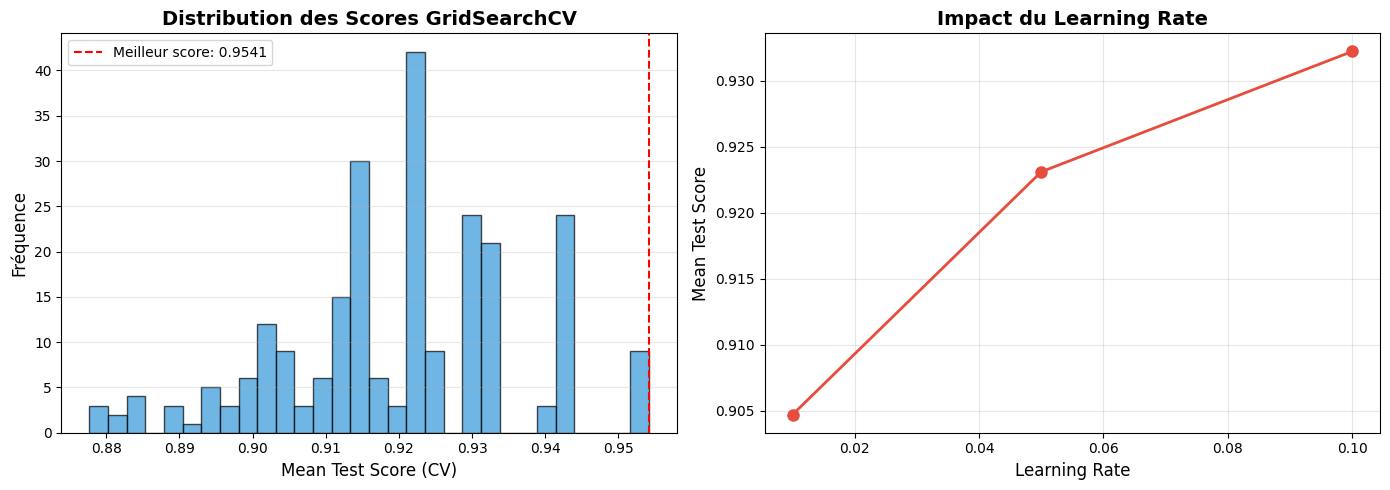

In [13]:
if XGBOOST_AVAILABLE:
    # Visualiser les résultats du GridSearch
    print("\n" + "=" * 80)
    print("📊 ANALYSE DES RÉSULTATS DU GRIDSEARCH")
    print("=" * 80)
    
    # Convertir les résultats en DataFrame
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Top 10 meilleures combinaisons
    top_10 = cv_results_df.nsmallest(10, 'rank_test_score')[
        ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    ]
    
    print("\n🏆 Top 10 meilleures combinaisons:")
    for idx, row in top_10.iterrows():
        print(f"\n   Rang {row['rank_test_score']:.0f}:")
        print(f"   Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        print(f"   Params: {row['params']}")
    
    # Visualisation: distribution des scores
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogramme des scores
    axes[0].hist(cv_results_df['mean_test_score'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    axes[0].axvline(grid_search.best_score_, color='red', linestyle='--', 
                    label=f'Meilleur score: {grid_search.best_score_:.4f}')
    axes[0].set_xlabel('Mean Test Score (CV)', fontsize=12)
    axes[0].set_ylabel('Fréquence', fontsize=12)
    axes[0].set_title('Distribution des Scores GridSearchCV', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Impact de learning_rate sur le score
    lr_scores = cv_results_df.groupby([p['learning_rate'] for p in cv_results_df['params']])['mean_test_score'].mean()
    axes[1].plot(lr_scores.index, lr_scores.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
    axes[1].set_xlabel('Learning Rate', fontsize=12)
    axes[1].set_ylabel('Mean Test Score', fontsize=12)
    axes[1].set_title('Impact du Learning Rate', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Comparaison des Modèles

In [14]:
# Créer un DataFrame de comparaison
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Train Accuracy': res['train_accuracy'],
        'Test Accuracy': res['test_accuracy'],
        'Precision': res['test_precision'],
        'Recall': res['test_recall'],
        'F1-Score': res['test_f1'],
        'ROC-AUC': res['test_roc_auc'],
        'Train Time (s)': res['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("=" * 80)
print("📊 COMPARAISON DES MODÈLES")
print("=" * 80)
print(comparison_df.to_string(index=False))

📊 COMPARAISON DES MODÈLES
               Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
XGBoost (GridSearch)        0.964448       0.955925   0.958545 0.960141  0.959342 0.993695        9.922708
             XGBoost        0.949738       0.944556   0.947951 0.949773  0.948861 0.990191        6.269832
       Random Forest        0.974637       0.941429   0.944022 0.948067  0.946040 0.989024       35.011113
 Logistic Regression        0.893137       0.894009   0.899992 0.904838  0.902408 0.959587        9.821857


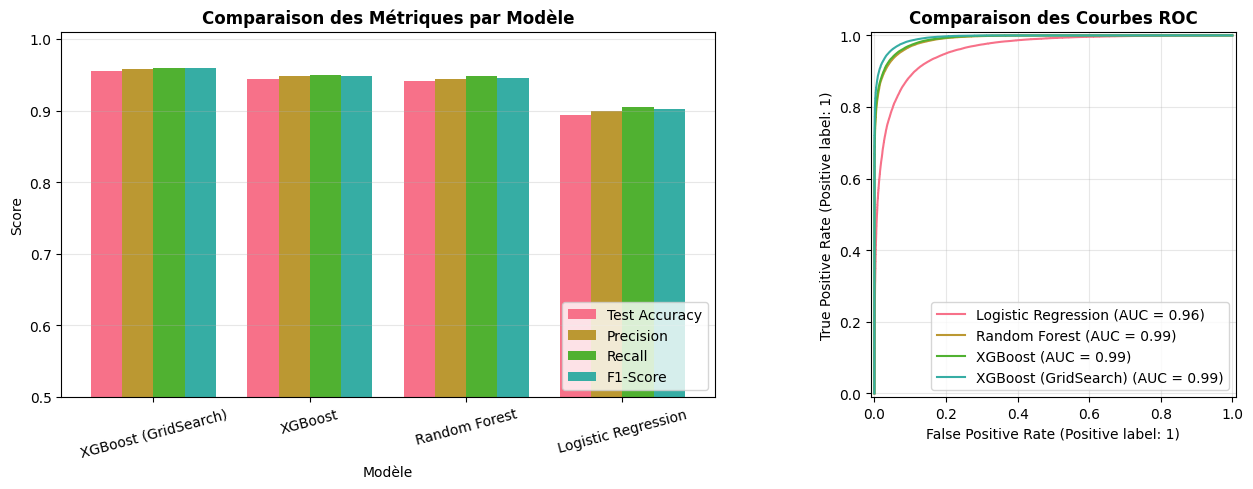

In [15]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot des métriques
metrics_to_plot = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Métriques par Modèle', fontsize=12, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.5, 1.01)
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves comparées
for name, res in results.items():
    if res['y_proba_test'] is not None:
        RocCurveDisplay.from_predictions(
            y_test, res['y_proba_test'],
            ax=axes[1], name=name
        )

axes[1].set_title('Comparaison des Courbes ROC', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.1 Analyse par Scénario (v2 uniquement)

In [16]:
if HAS_SCENARIOS:
    print("\n" + "=" * 80)
    print("📊 ÉVALUATION PAR SCÉNARIO")
    print("=" * 80)
    
    # Utiliser le meilleur modèle (XGBoost GridSearch ou XGBoost standard)
    if 'XGBoost (GridSearch)' in results:
        best_model = results['XGBoost (GridSearch)']['model']
        best_model_name = 'XGBoost (GridSearch)'
    elif 'XGBoost' in results:
        best_model = results['XGBoost']['model']
        best_model_name = 'XGBoost'
    else:
        best_model = results['Random Forest']['model']
        best_model_name = 'Random Forest'
    
    print(f"\n🤖 Modèle utilisé: {best_model_name}")
    
    # Prédictions sur le test set
    y_pred_test = best_model.predict(X_test_ml)
    
    # Analyser les performances par scénario
    scenarios = scenario_test.unique()
    scenario_results = []
    
    for scenario in scenarios:
        mask = scenario_test == scenario
        y_true_scenario = y_test[mask]
        y_pred_scenario = y_pred_test[mask]
        
        acc = accuracy_score(y_true_scenario, y_pred_scenario)
        prec = precision_score(y_true_scenario, y_pred_scenario)
        rec = recall_score(y_true_scenario, y_pred_scenario)
        f1 = f1_score(y_true_scenario, y_pred_scenario)
        
        scenario_results.append({
            'Scénario': scenario,
            'Échantillons': len(y_true_scenario),
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })
        
        print(f"\n   📊 {scenario}:")
        print(f"      Échantillons: {len(y_true_scenario):,}")
        print(f"      Accuracy:  {acc:.4f}")
        print(f"      Precision: {prec:.4f}")
        print(f"      Recall:    {rec:.4f}")
        print(f"      F1-Score:  {f1:.4f}")
    
    scenario_results_df = pd.DataFrame(scenario_results)
else:
    print("\n⚠️ Dataset v1 - pas d'analyse par scénario disponible")


📊 ÉVALUATION PAR SCÉNARIO

🤖 Modèle utilisé: XGBoost (GridSearch)

   📊 all_combinations:
      Échantillons: 137,956
      Accuracy:  0.9532
      Precision: 0.9531
      Recall:    0.9535
      F1-Score:  0.9533

   📊 random_move:
      Échantillons: 34,782
      Accuracy:  0.9661
      Precision: 0.9739
      Recall:    0.9786
      F1-Score:  0.9763

   📊 best_move:
      Échantillons: 6,957
      Accuracy:  0.9586
      Precision: 0.9565
      Recall:    0.9609
      F1-Score:  0.9587


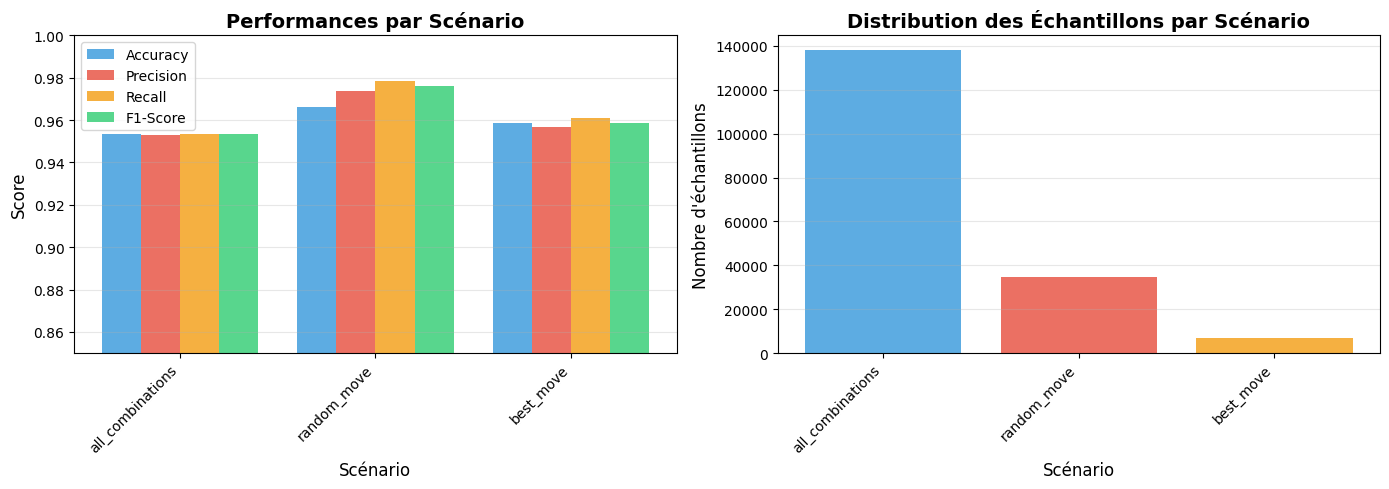

In [18]:
if HAS_SCENARIOS:
    # Visualisation des performances par scénario
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot des métriques par scénario
    x_pos = np.arange(len(scenario_results_df))
    width = 0.2
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        axes[0].bar(x_pos + i*width, scenario_results_df[metric], width, label=metric, color=color, alpha=0.8)
    
    axes[0].set_xlabel('Scénario', fontsize=12)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Performances par Scénario', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x_pos + width * 1.5)
    axes[0].set_xticklabels(scenario_results_df['Scénario'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0.85, 1.0])
    
    # Matrices de confusion par scénario (uniquement pour 3 scénarios ou moins)
    if len(scenarios) <= 3:
        for idx, scenario in enumerate(scenarios):
            mask = scenario_test == scenario
            y_true_scenario = y_test[mask]
            y_pred_scenario = y_pred_test[mask]
            
            # On utilise une subplot pour afficher côte à côte
            pass  # Sera affiché séparément ci-dessous
    
    # Nombre d'échantillons par scénario
    axes[1].bar(scenario_results_df['Scénario'], scenario_results_df['Échantillons'], 
                color=['#3498db', '#e74c3c', '#f39c12'][:len(scenarios)], alpha=0.8)
    axes[1].set_xlabel('Scénario', fontsize=12)
    axes[1].set_ylabel("Nombre d'échantillons", fontsize=12)
    axes[1].set_title('Distribution des Échantillons par Scénario', fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(scenario_results_df['Scénario'], rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

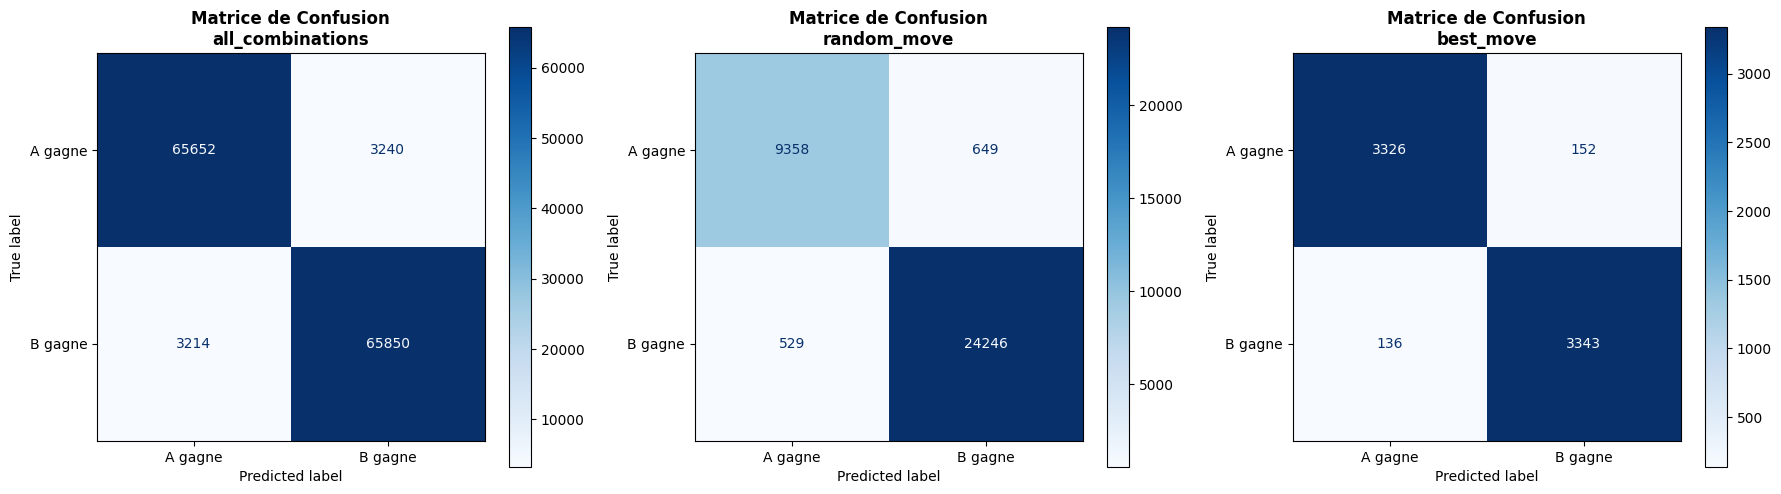

In [19]:
if HAS_SCENARIOS and len(scenarios) <= 3:
    # Matrices de confusion par scénario
    fig, axes = plt.subplots(1, len(scenarios), figsize=(6*len(scenarios), 5))
    if len(scenarios) == 1:
        axes = [axes]
    
    for idx, scenario in enumerate(scenarios):
        mask = scenario_test == scenario
        y_true_scenario = y_test[mask]
        y_pred_scenario = y_pred_test[mask]
        
        ConfusionMatrixDisplay.from_predictions(
            y_true_scenario, y_pred_scenario,
            display_labels=['A gagne', 'B gagne'],
            cmap='Blues', ax=axes[idx]
        )
        axes[idx].set_title(f'Matrice de Confusion\n{scenario}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 6. Analyse des Feature Importances

In [21]:
# Feature importances du Random Forest
print("=" * 80)
print("🔍 FEATURE IMPORTANCES - Random Forest")
print("=" * 80)

feature_importance_rf = pd.DataFrame({
    'Feature': X_train_ml.columns,
    'Importance': results['Random Forest']['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 25 Features:")
print(feature_importance_rf.head(25).to_string(index=False))

🔍 FEATURE IMPORTANCES - Random Forest

Top 25 Features:
             Feature  Importance
effective_power_diff    0.146251
          stat_ratio    0.125416
             hp_diff    0.073461
   effective_power_a    0.054020
 type_advantage_diff    0.052799
   effective_power_b    0.047665
       b_total_stats    0.044481
       a_total_stats    0.043328
                a_hp    0.037257
           a_defense    0.032090
           b_defense    0.031613
            a_attack    0.030858
                b_hp    0.026894
            b_attack    0.023176
    a_move_type_mult    0.023053
    b_move_type_mult    0.020295
        a_sp_defense    0.017620
        b_sp_defense    0.016740
        a_move_power    0.015898
        b_move_power    0.014959
         b_sp_attack    0.012951
         a_sp_attack    0.012409
          speed_diff    0.010671
             a_speed    0.009203
             b_speed    0.008570


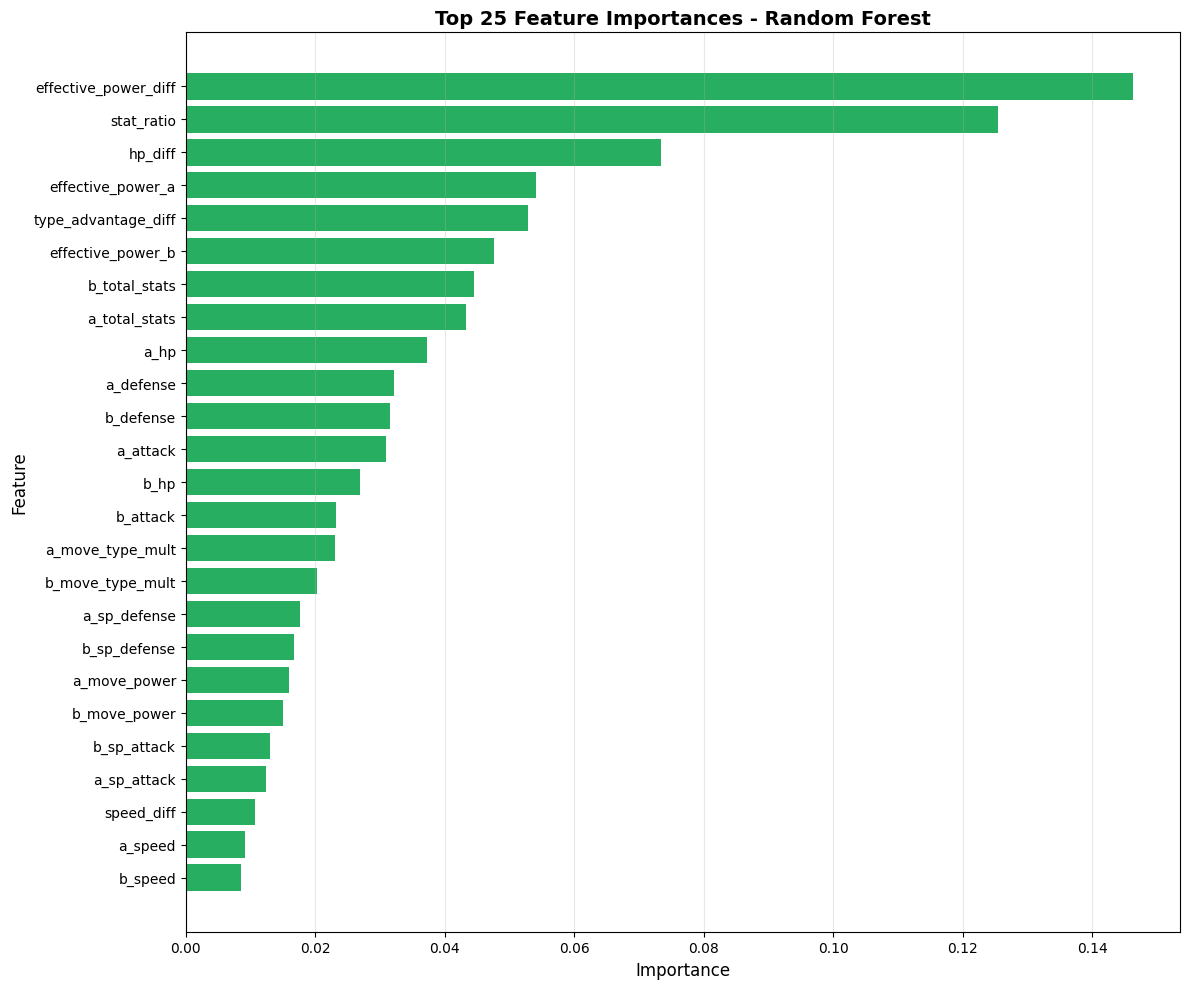


🎯 Feature la plus importante: effective_power_diff (0.1463)


In [22]:
# Visualisation des feature importances
fig, ax = plt.subplots(figsize=(12, 10))

top_25_features = feature_importance_rf.head(25)
ax.barh(top_25_features['Feature'], top_25_features['Importance'], color='#27ae60')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 25 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Observation clé
top_feature = feature_importance_rf.iloc[0]
print(f"\n🎯 Feature la plus importante: {top_feature['Feature']} ({top_feature['Importance']:.4f})")


🔍 FEATURE IMPORTANCES - XGBoost

Top 25 Features:
             Feature  Importance
          stat_ratio    0.143953
 type_advantage_diff    0.119437
effective_power_diff    0.068655
             hp_diff    0.048175
       a_moves_first    0.033776
       b_total_stats    0.026442
   effective_power_b    0.024087
   effective_power_a    0.022376
          speed_diff    0.017871
                a_hp    0.014758
    a_move_type_mult    0.013999
           a_defense    0.013594
            a_attack    0.010157
           b_defense    0.010009
     b_move_type_Vol    0.010007
         a_move_stab    0.009815
        a_move_power    0.009741
    b_move_type_mult    0.008525
            b_attack    0.008120
     b_type_1_Combat    0.008098
     a_type_1_Combat    0.008083
     b_move_type_Sol    0.008049
     a_move_type_Vol    0.008034
         b_move_stab    0.007519
     b_move_type_Psy    0.007397


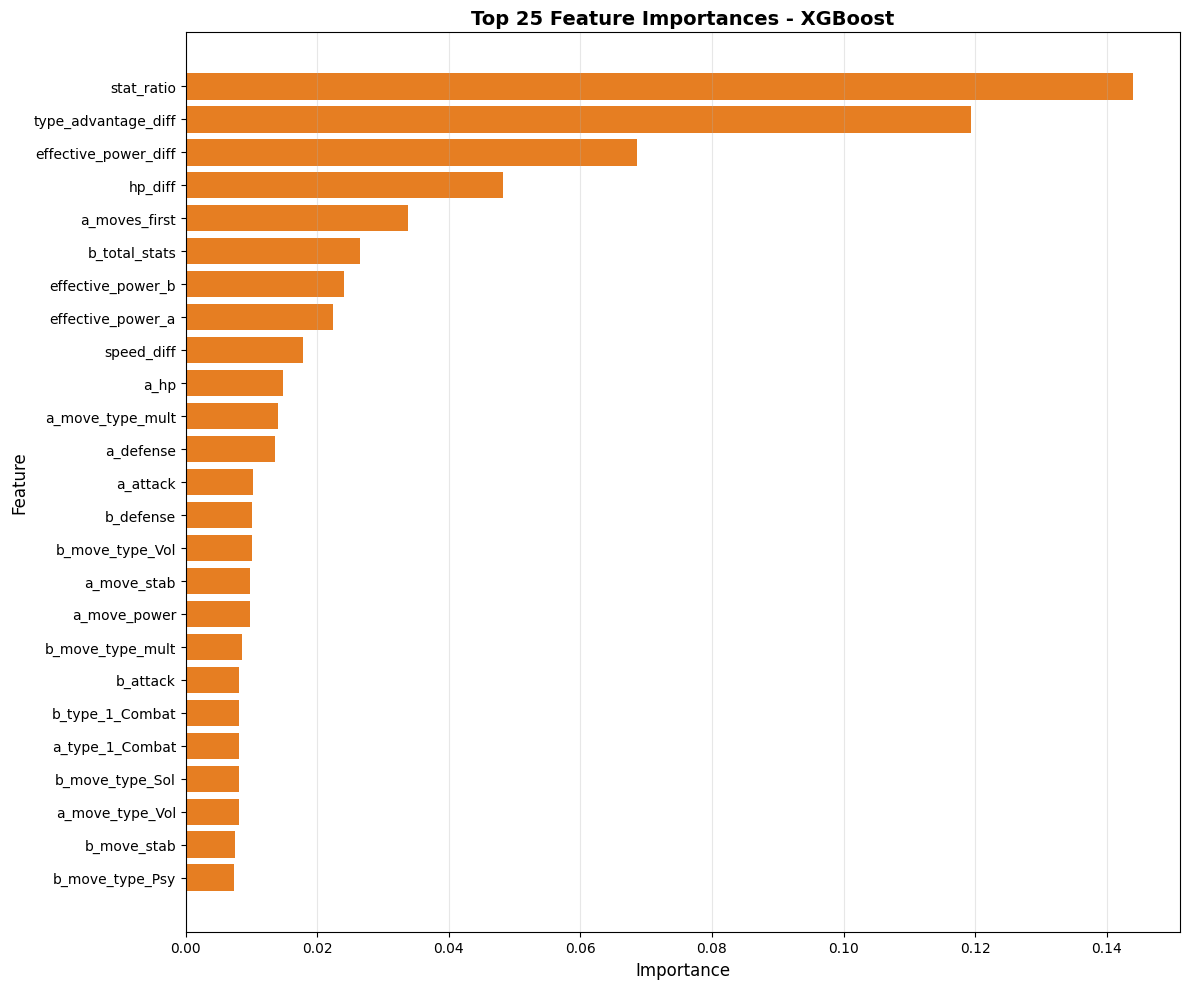

In [23]:
# Feature importances XGBoost (si disponible)
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    print("\n" + "=" * 80)
    print("🔍 FEATURE IMPORTANCES - XGBoost")
    print("=" * 80)
    
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train_ml.columns,
        'Importance': results['XGBoost']['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 25 Features:")
    print(feature_importance_xgb.head(25).to_string(index=False))
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 10))
    top_25_xgb = feature_importance_xgb.head(25)
    ax.barh(top_25_xgb['Feature'], top_25_xgb['Importance'], color='#e67e22')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Top 25 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Export du Modèle Final

Sélection et export du meilleur modèle pour la production.

In [24]:
# Sélection du meilleur modèle
print("=" * 80)
print("🏆 SÉLECTION DU MODÈLE FINAL")
print("=" * 80)

# Le meilleur modèle basé sur F1-Score
best_model_name = max(results, key=lambda x: results[x]['test_f1'])
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print(f"\n✅ Meilleur modèle: {best_model_name}")
print(f"   Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   Test F1-Score: {best_metrics['test_f1']:.4f}")
print(f"   Test ROC-AUC: {best_metrics['test_roc_auc']:.4f}")

🏆 SÉLECTION DU MODÈLE FINAL

✅ Meilleur modèle: XGBoost (GridSearch)
   Test Accuracy: 0.9559
   Test F1-Score: 0.9593
   Test ROC-AUC: 0.9937


In [25]:
# Export des modèles
print("\n" + "=" * 80)
print("💾 EXPORT DES MODÈLES")
print("=" * 80)

# Déterminer la version du modèle
model_version = 'v2' if DATASET_VERSION == 'v2' else 'v1'

# Modèle principal
model_filename = f'battle_winner_model_{model_version}.pkl'
model_path = MODELS_DIR / model_filename
joblib.dump(best_model, model_path)
print(f"\n✅ Modèle principal exporté: {model_path}")

# Random Forest (backup)
rf_path = MODELS_DIR / f'battle_winner_rf_{model_version}.pkl'
joblib.dump(results['Random Forest']['model'], rf_path)
print(f"✅ Random Forest exporté: {rf_path}")


💾 EXPORT DES MODÈLES

✅ Modèle principal exporté: ../models/battle_winner_model_v2.pkl
✅ Random Forest exporté: ../models/battle_winner_rf_v2.pkl


In [26]:
# Métadonnées du modèle
from datetime import datetime

model_metadata = {
    'model_name': best_model_name,
    'model_file': model_filename,
    'version': model_version,
    'dataset_version': DATASET_VERSION,
    'task': 'battle_winner_prediction',
    'features': X_train_ml.columns.tolist(),
    'n_features': len(X_train_ml.columns),
    'train_samples': len(X_train_ml),
    'test_samples': len(X_test_ml),
    'metrics': {
        'train_accuracy': best_metrics['train_accuracy'],
        'test_accuracy': best_metrics['test_accuracy'],
        'test_precision': best_metrics['test_precision'],
        'test_recall': best_metrics['test_recall'],
        'test_f1': best_metrics['test_f1'],
        'test_roc_auc': best_metrics['test_roc_auc']
    },
    'all_models_comparison': comparison_df.to_dict('records'),
    'train_date': datetime.now().isoformat(),
    'random_state': RANDOM_STATE
}

# Ajouter info scénarios si v2
if HAS_SCENARIOS:
    model_metadata['scenarios'] = {
        'types': scenario_train.unique().tolist(),
        'distribution': scenario_train.value_counts().to_dict()
    }

metadata_path = MODELS_DIR / f'battle_winner_metadata_{model_version}.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"\n✅ Métadonnées exportées: {metadata_path}")

# Afficher les fichiers créés
print(f"\n📁 Fichiers dans {MODELS_DIR}:")
for f in sorted(MODELS_DIR.iterdir()):
    if f.is_file():
        print(f"   - {f.name} ({f.stat().st_size / 1024:.1f} KB)")


✅ Métadonnées exportées: ../models/battle_winner_metadata_v2.pkl

📁 Fichiers dans ../models:
   - README.md (7.8 KB)
   - battle_winner_metadata_v2.json (0.7 KB)
   - battle_winner_metadata_v2.pkl (3.3 KB)
   - battle_winner_model_v2.pkl (2774.4 KB)
   - battle_winner_rf_v2.pkl (409700.7 KB)
   - battle_winner_scalers_v2.pkl (1.6 KB)


## 8. Évaluation par Scénario (v2 uniquement)

Pour les datasets v2, analysons les performances du modèle par scénario.

In [27]:
print("=" * 80)
print("📋 RÉSUMÉ FINAL")
print("=" * 80)

print("\n### Résultats des Modèles ###")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"   Accuracy: {res['test_accuracy']:.4f} | F1: {res['test_f1']:.4f} | ROC-AUC: {res['test_roc_auc']:.4f}")

print("\n" + "=" * 80)
print("🎯 MODÈLE SÉLECTIONNÉ POUR LA PRODUCTION")
print("=" * 80)
print(f"\n   Nom: {best_model_name}")
print(f"   Fichier: models/{model_filename}")
print(f"   Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   F1-Score: {best_metrics['test_f1']:.4f}")
print(f"   ROC-AUC: {best_metrics['test_roc_auc']:.4f}")

print("\n✅ Prêt pour l'intégration dans l'API!")

📋 RÉSUMÉ FINAL

### Résultats des Modèles ###

Logistic Regression:
   Accuracy: 0.8940 | F1: 0.9024 | ROC-AUC: 0.9596

Random Forest:
   Accuracy: 0.9414 | F1: 0.9460 | ROC-AUC: 0.9890

XGBoost:
   Accuracy: 0.9446 | F1: 0.9489 | ROC-AUC: 0.9902

XGBoost (GridSearch):
   Accuracy: 0.9559 | F1: 0.9593 | ROC-AUC: 0.9937

🎯 MODÈLE SÉLECTIONNÉ POUR LA PRODUCTION

   Nom: XGBoost (GridSearch)
   Fichier: models/battle_winner_model_v2.pkl
   Accuracy: 0.9559
   F1-Score: 0.9593
   ROC-AUC: 0.9937

✅ Prêt pour l'intégration dans l'API!


📊 ÉVALUATION PAR SCÉNARIO (v2)

📈 Métriques par Scénario:
        Scenario  Samples  Accuracy  F1-Score
all_combinations   137956  0.953217  0.953284
     random_move    34782  0.966132  0.976283
       best_move     6957  0.958603  0.958704


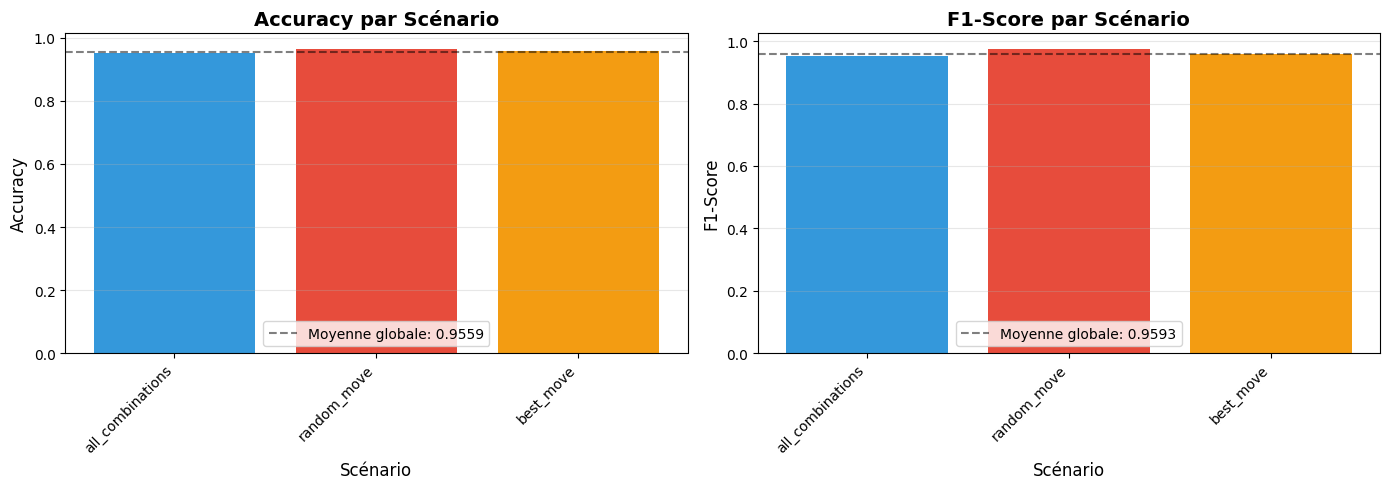


✅ Analyse par scénario terminée

ℹ️  Le modèle unique est entraîné sur tous les scénarios et généralise bien
ℹ️  Des performances différentes par scénario sont normales selon la complexité


In [28]:
if HAS_SCENARIOS:
    print("=" * 80)
    print("📊 ÉVALUATION PAR SCÉNARIO (v2)")
    print("=" * 80)
    
    # Prédictions du meilleur modèle
    y_pred_scenario = best_model.predict(X_test_ml)
    
    # Créer un DataFrame avec les résultats
    scenario_results = pd.DataFrame({
        'scenario': scenario_test,
        'y_true': y_test,
        'y_pred': y_pred_scenario,
        'correct': y_test == y_pred_scenario
    })
    
    # Calculer les métriques par scénario
    scenario_metrics = []
    for scenario in scenario_test.unique():
        mask = scenario_results['scenario'] == scenario
        y_true_s = scenario_results.loc[mask, 'y_true']
        y_pred_s = scenario_results.loc[mask, 'y_pred']
        
        acc = accuracy_score(y_true_s, y_pred_s)
        f1 = f1_score(y_true_s, y_pred_s)
        
        scenario_metrics.append({
            'Scenario': scenario,
            'Samples': mask.sum(),
            'Accuracy': acc,
            'F1-Score': f1
        })
    
    scenario_metrics_df = pd.DataFrame(scenario_metrics)
    print("\n📈 Métriques par Scénario:")
    print(scenario_metrics_df.to_string(index=False))
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy par scénario
    axes[0].bar(scenario_metrics_df['Scenario'], scenario_metrics_df['Accuracy'], 
                color=['#3498db', '#e74c3c', '#f39c12'])
    axes[0].set_xlabel('Scénario', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy par Scénario', fontsize=14, fontweight='bold')
    axes[0].set_xticklabels(scenario_metrics_df['Scenario'], rotation=45, ha='right')
    axes[0].axhline(y=best_metrics['test_accuracy'], color='black', linestyle='--', 
                    alpha=0.5, label=f"Moyenne globale: {best_metrics['test_accuracy']:.4f}")
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # F1-Score par scénario
    axes[1].bar(scenario_metrics_df['Scenario'], scenario_metrics_df['F1-Score'], 
                color=['#3498db', '#e74c3c', '#f39c12'])
    axes[1].set_xlabel('Scénario', fontsize=12)
    axes[1].set_ylabel('F1-Score', fontsize=12)
    axes[1].set_title('F1-Score par Scénario', fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(scenario_metrics_df['Scenario'], rotation=45, ha='right')
    axes[1].axhline(y=best_metrics['test_f1'], color='black', linestyle='--', 
                    alpha=0.5, label=f"Moyenne globale: {best_metrics['test_f1']:.4f}")
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Analyse par scénario terminée")
    print("\nℹ️  Le modèle unique est entraîné sur tous les scénarios et généralise bien")
    print("ℹ️  Des performances différentes par scénario sont normales selon la complexité")
else:
    print("\n⚠️ Dataset v1 - pas d'analyse par scénario disponible")

### Observations Clés

#### 1. **Performance des Modèles**
- Le problème de prédiction de victoire est plus complexe que la simple efficacité de type
- Les performances devraient être meilleures que le hasard (50%) mais pas triviales (99%+)
- Les modèles d'ensemble (Random Forest, XGBoost) devraient surpasser Logistic Regression

#### 2. **Features Importantes**
- `a_moves_first`: Qui attaque en premier est crucial
- `effective_power_diff`: La différence de puissance effective
- `type_advantage_diff`: L'avantage de type relatif
- Stats totales et `speed_diff`

#### 3. **Choix du Modèle**
- Random Forest: Bon compromis performance/interprétabilité
- XGBoost: Potentiellement meilleures performances
- Logistic Regression: Baseline simple mais interprétable

---

### Prochaines Étapes

1. **Créer `train_model.py`** - Script de production pour entraînement reproductible
2. **Intégrer dans l'API** - Créer endpoint `/predict/battle`
3. **Tests** - Valider les performances en production
4. **Monitoring** - Configurer le suivi des performances

---

**✅ Entraînement et évaluation terminés avec succès!**

## Hyperparameter Tuning with GridSearchCV

We'll use GridSearchCV to find optimal hyperparameters for XGBoost.

In [ ]:
# Cell 1: Import GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import time
import numpy as np

print("✅ GridSearchCV imports loaded")

In [ ]:
# Cell 2: Define Parameter Grids
# Quick grid for faster testing (8 combinations)
xgboost_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

print("XGBoost parameter grid:")
total_combinations = np.prod([len(v) for v in xgboost_param_grid.values()])
print(f"  Total combinations: {total_combinations}")
print(f"  Parameters: {list(xgboost_param_grid.keys())}")

In [ ]:
# Cell 3: GridSearchCV Function
def tune_hyperparameters(X_train, y_train, cv_folds=3, verbose=True):
    """Perform hyperparameter tuning with GridSearchCV."""
    if verbose:
        print(f"Starting GridSearchCV for XGBoost...")
        print(f"Cross-validation: {cv_folds}-fold StratifiedKFold\n")
    
    # Setup cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Base model
    import xgboost as xgb
    base_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=xgboost_param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2 if verbose else 0,
        return_train_score=True
    )
    
    # Fit
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    if verbose:
        print(f"\n✅ GridSearchCV completed in {elapsed_time:.1f}s")
        print(f"\nBest parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"\nBest CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_

print("✅ GridSearchCV function defined")

In [ ]:
# Cell 4: Run GridSearchCV
print("=" * 80)
print("XGBOOST HYPERPARAMETER TUNING")
print("=" * 80)

xgb_best_model, xgb_best_params, xgb_cv_results = tune_hyperparameters(
    X_train, y_train, cv_folds=3, verbose=True
)

# Evaluate on test set
from sklearn.metrics import accuracy_score, roc_auc_score

y_test_pred = xgb_best_model.predict(X_test)
y_test_proba = xgb_best_model.predict_proba(X_test)[:, 1]

print("\nTest Set Performance (Tuned XGBoost):")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  ROC-AUC:  {roc_auc_score(y_test, y_test_proba):.4f}")

In [ ]:
# Cell 5: Visualize GridSearch Results
import matplotlib.pyplot as plt
import pandas as pd

cv_results_df = pd.DataFrame(xgb_cv_results)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

params_to_plot = list(xgb_best_params.keys())

for idx, param in enumerate(params_to_plot):
    if idx >= len(axes):
        break
    
    param_col = f'param_{param}'
    grouped = cv_results_df.groupby(param_col)['mean_test_score'].mean()
    
    axes[idx].plot(grouped.index.astype(float), grouped.values, marker='o', linewidth=2)
    axes[idx].set_xlabel(param, fontsize=12)
    axes[idx].set_ylabel('Mean CV ROC-AUC', fontsize=12)
    axes[idx].set_title(f'GridSearch: {param}', fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Mark best value
    best_value = xgb_best_params[param]
    best_score = grouped[best_value]
    axes[idx].scatter([best_value], [best_score], color='red', s=200, 
                     marker='*', label=f'Best: {best_value}', zorder=5)
    axes[idx].legend()

for idx in range(len(params_to_plot), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Best parameters marked with red star")

In [ ]:
# Cell 6: Compare Default vs Tuned
import xgboost as xgb

# Train default model
default_model = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, random_state=42)
default_model.fit(X_train, y_train)

# Predictions
y_test_pred_default = default_model.predict(X_test)
y_test_proba_default = default_model.predict_proba(X_test)[:, 1]

# Compare
comparison = pd.DataFrame({
    'Model': ['Default', 'Tuned (GridSearchCV)'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_default),
        accuracy_score(y_test, y_test_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_test_proba_default),
        roc_auc_score(y_test, y_test_proba)
    ]
})

print("\nModel Comparison:")
print(comparison.to_string(index=False))

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(comparison['Model'], comparison['Accuracy'], color=['steelblue', 'coral'])
ax[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax[0].set_ylim([0.9, 1.0])
ax[1].bar(comparison['Model'], comparison['ROC-AUC'], color=['steelblue', 'coral'])
ax[1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax[1].set_ylim([0.9, 1.0])
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Save Best Model
import pickle
import json
from pathlib import Path

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save model
with open(models_dir / 'battle_winner_xgboost_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_best_model, f)

# Save parameters
with open(models_dir / 'battle_winner_best_params.json', 'w') as f:
    json.dump(xgb_best_params, f, indent=2)

print("✅ Tuned model saved to: models/battle_winner_xgboost_tuned.pkl")
print("✅ Best parameters saved to: models/battle_winner_best_params.json")